In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

from glob import glob


def cell_attributes():
    import yaml

    with open("../configs/prw/grid_id0/cell0.yaml") as f:
        configs = yaml.safe_load(f)
    D = configs["D"]
    alpha = configs["alpha"]
    return D, alpha


def plot_distributions(cms):
    from substrate.substrates import Substrate

    sub_generator = Substrate(N_mesh=200, L_box=50)
    chi = sub_generator.two_state_sub()

    fig = plt.figure(figsize=(5, 5))

    ax = plt.subplot2grid((3, 3), (1, 0), rowspan=2)
    ax.hist(cms.y.values, color="blue", orientation="horizontal")
    ax.set_ylim([0, 50])
    ax.set_xlabel("PDF(y)")
    ax.set_ylabel("y")

    ax = plt.subplot2grid((3, 3), (0, 1), colspan=2)
    ax.hist(cms.x.values, color="red")
    ax.set_xlim([0, 50])
    ax.set_xlabel("x")
    ax.set_ylabel("PDF(x)")

    ax = plt.subplot2grid((3, 3), (1, 1), colspan=2, rowspan=2)
    ax.scatter(cms.x, cms.y, c=range(cms.shape[0]), cmap="viridis")
    ax.contour(
        chi, levels=[0.5], colors=["black"], linewidths=[3], extent=[0, 50, 0, 50]
    )
    import matplotlib as mplt

    times = cms["time[hr]"].values
    norm = mplt.colors.Normalize(vmin=times[0], vmax=times[-1] / 24)
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap="viridis"), location="bottom", pad=-0.2
    )
    cbar.set_label("Days")
    ax.axis("off")


def hist_hopping_time(cms):
    # cms["bin"] = [0 if np.fabs(x-12.5)<2.5 else 1 for x in cms.x.values]

    # index one after which the cell has hopped
    hopped_indx = np.where(np.diff(cms.bin.values) != 0)[0]
    cum_time_before_hop = np.diff(cms.iloc[hopped_indx]["time[hr]"].values, prepend=0)
    return cum_time_before_hop


def read_all_files(pathname_fmt, n_workers):
    files = glob(pathname_fmt)
    with Pool(processes=n_workers) as p:
        res = p.map_async(_read_file, files)
        p.close()
        p.join()

    res = res.get(timeout=1)
    return pd.concat(res).reset_index(drop=True)


def _read_file(file):
    df = pd.read_csv(file).drop(columns=["Unnamed: 0"])
    df["time[hr]"] = df.index * 2000 * 0.002 * 8 / 60
    return df


def _calc_v(x, dt):
    # x is in mu
    # dt is in hr
    return np.diff(x) / dt


def _calc_a(x, dt):
    # x is in mu
    # dt is in hr
    x_c = x[1:-1]
    x_after = x[2:]
    x_before = x[:-2]
    return (x_after - 2 * x_c + x_before) / dt**2


def compute_v_a(x, dt):
    v = _calc_v(x, dt)
    a = _calc_a(x, dt)
    df = pd.DataFrame(x, columns=["x"])
    df = df.iloc[1:-1]
    df["v"] = v[1:]
    df["a"] = a
    return df


def map_one_pair(x_v_a, nbins, dx, x_min, dv, v_min):

    acc_map = np.empty(shape=(nbins, nbins))
    acc_map[:] = np.nan

    x_v_a["xbin"] = np.floor((x_v_a.x.values - x_min) / dx)
    x_v_a["vbin"] = np.floor((x_v_a.v.values - v_min) / dv)

    x_v_a = x_v_a.astype({"xbin": "int"})
    x_v_a = x_v_a.astype({"vbin": "int"})

    for (xbin, vbin), df in x_v_a.groupby(["xbin", "vbin"]):
        acc_map[vbin, xbin] = df.a.mean()

    return acc_map


def plot_trajectories(pair):
    n_t = pair.shape[0] // 2
    t = np.arange(n_t) * 10 / 60
    plt.figure(figsize=(5, 1))
    plt.plot(t, pair[pair.id == "c0"].x, color="orange", lw=3)
    plt.plot(t, pair[pair.id == "c1"].x, color="purple", lw=3)
    plt.xlabel("time [hr]")
    plt.ylabel(r"$x$ [$\mu$m]")
    plt.show()


# Maps for Buckner's data

In [12]:
# data file for MDA_MB_231 cell pairs on two-state micropattern
src = "/mnt/c/Users/pedro/Downloads/pnas.2016602118.sd01.txt"
data = pd.read_csv(src, sep=" ", header=None)
n_pairs = data.shape[0] // 2


Reorganize the data structure: Position, velocity, acceleration for each pair

In [41]:
pair_stats = []
for k in range(n_pairs):

    pair = data.iloc[k * 2 : k * 2 + 2].T
    pair.columns = ["c0", "c1"]
    pair = pair.dropna()
    pair_x_v_a = None

    for col in pair.columns:
        x_v_a = compute_v_a(pair[col].values, dt=10 / 60)
        x_v_a["time [min]"] = x_v_a.index * 10
        x_v_a["id"] = col
        x_v_a["pair"] = k
        pair_x_v_a = pd.concat([pair_x_v_a, x_v_a])

    pair_stats.append(pair_x_v_a)

pair_stats_df = pd.concat(pair_stats)


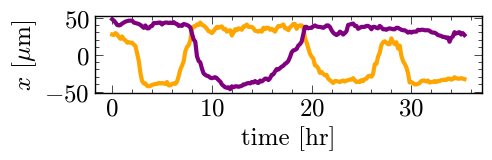

In [55]:
plot_trajectories(pair_stats[2])


Stats across all cell pairs -- global bounds

In [43]:
x_min = pair_stats_df.x.min()
x_max = pair_stats_df.x.max()
v_min = pair_stats_df.v.min()
v_max = pair_stats_df.v.max()
a_min = pair_stats_df.a.min()
a_max = pair_stats_df.a.max()

print(f"x: [{x_min:.3f}, {x_max:.3f}] mu")
print(f"v: [{v_min:.3f}, {v_max:.3f}] mu/hr")
print(f"a: [{a_min:.3f}, {a_max:.3f}] mu/hr^2")


x: [-51.053, 50.433] mu
v: [-252.721, 384.912] mu/hr
a: [-2216.160, 2332.800] mu/hr^2


Define one acceleration map bounds for everyone

In [44]:
nbins = 30
dx = (x_max - x_min) / (nbins - 1)
dv = (v_max - v_min) / (nbins - 1)

Throw together all the observations -- cells within the same pair and cells from different pairs

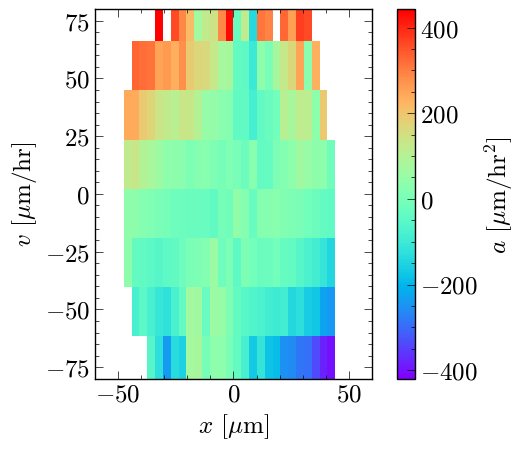

In [45]:
# df = pair_stats_df.query("v < 80 and v > -80 and x < 45 and x > -45").copy()
# a_maps_mean = map_one_pair(df, nbins, dx, x_min, dv, v_min)

# plt.imshow(
#     a_maps_mean, origin="lower", extent=[x_min, x_max, v_min, v_max], cmap="rainbow"
# )
# cbar = plt.colorbar()
# plt.xlabel(r"$x$ [$\mu$m]")
# plt.ylabel(r"$v$ [$\mu$m/hr]")
# cbar.set_label(r"$a$ [$\mu$m/hr$^2$]")
# plt.xlim([-60, 60])
# plt.ylim([-80, 80])
# plt.show()


One cell in isolation
- take cell $i$
- consider when nuclei are $\ell=25\mu \text{m}$ apart

In [46]:
df_0 = pair_stats_df.query("id=='c0'")
df_1 = pair_stats_df.query("id=='c1'")

df_0_isolated = df_0[np.fabs(df_0.x - df_1.x) > 25].copy()
df_1_isolated = df_1[np.fabs(df_0.x - df_1.x) > 25].copy()


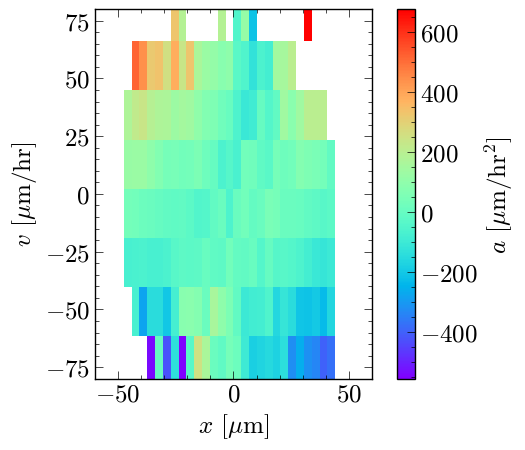

In [62]:
df_0_isolated_lim = df_0_isolated.query("v < 80 and v > -80 and x < 45 and x > -45").copy()

a_maps_mean = map_one_pair(df_0_isolated_lim, nbins, dx, x_min, dv, v_min)

plt.imshow(
    a_maps_mean, origin="lower", extent=[x_min, x_max, v_min, v_max], cmap="rainbow"
)
cbar = plt.colorbar()
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$v$ [$\mu$m/hr]")
cbar.set_label(r"$a$ [$\mu$m/hr$^2$]")
plt.xlim([-60, 60])
plt.ylim([-80, 80])
plt.show()
